In [1]:
import _base_path
import numpy as np
import pandas as pd
import spacy
from spacy import displacy
from resources.spans import SpanCollection, SpanExtractor
from resources.models import DummyModel
from resources.data_io import load_mappings
from resources.tokenization import WordTokenizer
from TrainerClassic import TrainerClassic

import matplotlib.pyplot as plt

c:\Users\Korbi\Documents\Uni\PhD\23-03_BaseLines\code\resources\spans.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
LABEL  = 'hazard-category'
COLUMN = f'{LABEL.split("-")[0]}-title'

# Load data:

In [3]:
# load data:
incidents = pd.read_csv("incidents/incidents_final.csv", index_col=0).drop(columns=[COLUMN])

# parse products:
incidents['product'].fillna('', inplace=True)
incidents['product-category'].fillna('', inplace=True)
incidents['product-text']     = [SpanCollection.parse(p) for p in incidents['product-text'].fillna('')]

# parse hazards:
incidents['hazard'].fillna('', inplace=True)
incidents['hazard-category'].fillna('', inplace=True)
incidents['hazard-text']      = [SpanCollection.parse(h) for h in incidents['hazard-text'].fillna('')]

# parse suppliers:
incidents['supplier-title']   = [SpanCollection.parse(s) for s in incidents['supplier-title'].fillna('')]
incidents['supplier-text']    = [SpanCollection.parse(s) for s in incidents['supplier-text'].fillna('')]

# fill nan-values:
incidents['country'].fillna('na', inplace=True)

def print_column(column:str, n:int=10):
    try:               values = np.unique(np.concatenate(incidents[column].values))
    except ValueError: values = np.unique(incidents[column].values)
    counts = np.array([sum([v in label for label in incidents[column].values]) for v in values])

    idx = np.argsort(counts)[::-1]
    values = values[idx]
    counts = counts[idx]
    
    print(f'Column "{column}" (n = {len(values):d}):\n')
    for v, n in zip(values[:n], counts[:n]):
        print(f'  {v}:{" "*(50-len(v))}{sum([v in label for label in incidents[column].values]):5d}')

# print unique counts:
for c in incidents.columns:
    print(f'  {c}:{" "*(20-len(c))}{len(incidents[c].drop_duplicates()):5d}')

  year:                   29
  month:                  12
  day:                    31
  url:                  7546
  title:                7389
  text:                 7619
  product:              1931
  product_category:       60
  product_text:         7619
  hazard:                409
  hazard_category:        12
  hazard_text:          7619
  supplier_title:       7619
  supplier_text:        7619
  language:                6
  country:                15
  product_title:        3337


# Analysis:
## Extract Coefficients:

In [4]:
models, vocab = [], []
for i in range(5):
    t = TrainerClassic.load(f'../models/bow-lr/bow-lr-{LABEL}-{i:d}/')
    models.append(t._model)
    vocab.append(t.embedding.tokenizer._vocab)

# Row and column labels:
classes = load_mappings("incidents/splits/", LABEL)
tokens  = list(set(np.concatenate(vocab)))
tokens.sort()

# importance:
coefficients = np.zeros((len(classes), len(tokens)), dtype=float)
for m, v in zip(models, vocab):
    # create index-mapping: 
    idx = [tokens.index(t) for t in v]

    for i, c in enumerate(m):
        if not isinstance(c, DummyModel):
            coefficients[i,idx] += c.coef_[0]

# average over 5 splits:
coefficients /= 5.

## Filter out all zero columns: 

In [5]:
idx = np.unique(np.nonzero(coefficients)[1])

coefficients_filtered = coefficients[:,idx]
tokens_filtered = [tokens[i] for i in idx]

In [6]:
# filter out numbers and special tokens:
i = list(tokens_filtered).index('a')
print(i)

tokens_filtered = tokens_filtered[i:]
coefficients_filtered = coefficients_filtered[:,i:]

69


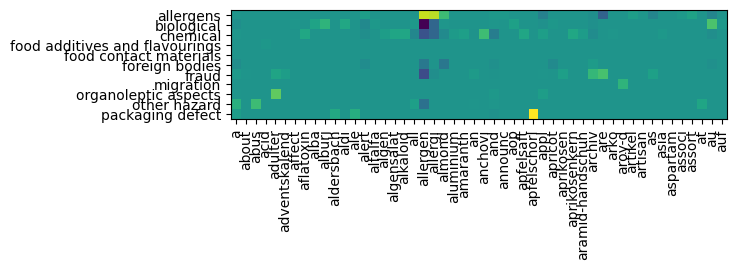

In [7]:
plt.imshow(coefficients_filtered[:50,:50])
plt.yticks(ticks=np.arange(min(len(classes), 50)), labels=classes[:50])
plt.xticks(ticks=np.arange(min(len(tokens_filtered), 50)), labels=tokens_filtered[:50], rotation=90)
plt.show()

## Calculate most important tokens:

In [8]:
most_important_tokens = {}

for i, c in enumerate(classes):
    idx = np.argsort(coefficients_filtered[i])[::-1]
    
    most_important_tokens[c] = {
        tokens_filtered[j]:coefficients_filtered[i,j]
        for j in idx
        if coefficients_filtered[i, j] > 0.
    }

In [9]:
for c in most_important_tokens:
    print(f'{c.upper()}: {", ".join(list(most_important_tokens[c].keys())[:10])}, ...')

ALLERGENS: undeclar, thereof, withdrawn, allergen, allergi, mustard, sultana, coconut, rice, raisin, ...
BIOLOGICAL: salmonella, listeria, bacteria, mould, noroviru, coli, risk, e., ham, pistachio, ...
CHEMICAL: ethylen, level, sanit, cyanid, lead, oxid, oil, pressling, tuna, histamin, ...
FOOD ADDITIVES AND FLAVOURINGS: jelli, high, cup, withdraw, of, level, ltd, in, mini, cake, ...
FOOD CONTACT MATERIALS: , ...
FOREIGN BODIES: foreign, metal, piec, insect, extran, fragment, glass, plastic, gerieben, minc, ...
FRAUD: inspect, without, english, unapprov, mislabel, misbrand, prepackag, report, inelig, label, ...
MIGRATION: schafskäs, fortun, silikon-muffinbackform, migrat, nylon, holzschal, kokosnusscrem, holzgriff, aroy-d, kochbesteck, ...
ORGANOLEPTIC ASPECTS: spoilag, rancid, uht, off, adulter, quality/spoilag, odour, bratmax, still, drink, ...
OTHER HAZARD: undercook, process, haccp, jelli, choke, stockman, deviat, firm, yoghurt, specifi, ...
PACKAGING DEFECT: apfelschorl, sparkl, d

## Calculate overlap:

In [10]:
mit_all = np.concatenate([list(e.keys()) for e in most_important_tokens.values()])
mit_unique = np.unique(mit_all)

print(f'Overlap: {len(mit_all)/len(mit_unique):.2f}')

Overlap: 1.28


In [11]:
counts = {}
for mit in mit_unique:
    tmp = [key 
        for key in most_important_tokens
        if mit in most_important_tokens[key].keys()
    ]

    if len(tmp) > 1: counts[mit] = tmp

In [12]:
len(counts)

219

# Extract spans

In [13]:
tokenizer = WordTokenizer()
tokenizer._vocab.extend(tokens)
tokenizer.train = False

In [14]:
extractor = SpanExtractor(
    set([', '.join(ls) for ls in incidents[LABEL.split('_')[0]]]),
    p_prefix=.6,
    p_suffix=.5,
    t_stopword=20
)
print('Prefixes:', extractor.prefixes)
print('Suffixes:', extractor.suffixes)


Prefixes: {'unauthorised': 0.6685544217687075, 'too': 0.6005257936507937, 'high': 0.8183292282430215, 'content': 0.610898001175779}
Suffixes: {'product': 0.5326190476190475, 'thereof': 0.5310119047619047}


In [15]:
data = []

for txt, lbls in incidents[['title', LABEL]].values:
    tok_out = tokenizer(txt, return_offsets_mapping=True)
    tkns = np.array([tokenizer._vocab[i] for i in tok_out['input_ids']])
    spns = tok_out['offset_mapping']

    importance = np.zeros(tkns.shape, dtype=float)
    for c in classes:
        for i, t in enumerate(tkns):
            if c in lbls:
                try: importance[i] += most_important_tokens[c][t]
                except KeyError: pass

            else:
                try: importance[i] -= most_important_tokens[c][t]
                except KeyError: pass

    spns = extractor.find([[t] for t in tkns[importance > 0]], txt)
    data.append((lbls, tkns[importance > 0], spns, importance[importance > 0]))

print(f'Percent of Texts with evidence for class: {np.mean([len(s) > 0 for _,_,s,_ in data])*100:.2f}%')

Percent of Texts with evidence for class: 85.14%


# Spans:

In [16]:
incidents[COLUMN] = [s for _,_,s,_ in data]

In [17]:
nlp = spacy.load("en_core_web_sm")

In [18]:
i = np.random.choice(incidents.index)
txt = nlp(incidents['title'].values[i])
txt.spans["sc"] = []

print(incidents[LABEL].values[i])
spans = [txt.char_span(l.start,l.stop, LABEL[:3].upper()) for l in incidents[COLUMN].values[i]]
for span in [incidents['title'].values[i][l] for l in incidents[COLUMN].values[i]]:
    print('[...]', span, '[...]')

#txt.set_ents(txt.ents + tuple([span for span in spans if span is not None]))
txt.spans["sc"] = tuple(txt.spans["sc"]) + tuple([span for span in spans if span is not None])

#displacy.render(txt, style='ent')
displacy.render(txt, style='span')

['packaging defect']
[...] Beer [...]
[...] cans [...]


# Save dataframe:

In [19]:
# concat products:
incidents['product']          = ['|'.join(p) for p in incidents['product']]
incidents['product-category'] = ['|'.join(p) for p in incidents['product-category']]
incidents['product-text']     = [str(p) for p in incidents['product-text']]

# concat hazards:
incidents['hazard']           = ['|'.join(h) for h in incidents['hazard']]
incidents['hazard-category']  = ['|'.join(h) for h in incidents['hazard-category']]
incidents['hazard-text']      = [str(h) for h in incidents['hazard-text']]

# concat suppliers:
incidents['supplier-title']   = [str(s) for s in incidents['supplier-title']]
incidents['supplier-text']    = [str(s) for s in incidents['supplier-text']]

incidents[COLUMN]             = [str(s) for s in incidents[COLUMN]]

incidents

,year,month,day,url,title,text,product,product_category,product_text,hazard,hazard_category,hazard_text,supplier_title,supplier_text,language,country,product_title,hazard_title
0,2015,5,26,https://www.fda.gov/Safety/Recalls/ArchiveReca...,2015 - House of Spices (India) Inc. Issues Ale...,"April 23, 2015 – Flushing, NY – House of Spic...",dried apricots,fruits and vegetables,"(98,139)|(429,475)|(744,786)",undeclared sulphite,allergens,"(167,249)","(7,34)","(33,47)",en,us,"(49,50)","(16,21)|(43,50)"
1,2022,5,25,https://www.fda.gov/safety/recalls-market-with...,Supplier J.M. Smucker Co.’s Jif Recall Prompts...,"(Miami, FL – May 24, 2022) - J.M. Smucker Co.’...",peanuts,"nuts, nut products and seeds","(452,517)|(533,559)|(584,614)",salmonella,biological,"(258,289)|(936,968)|(1117,1165)|(1252,1305)","(53,61)","(0,9)|(129,137)|(360,368)|(448,456)|(665,673)|...",en,us,"(14,20)|(28,30)|(85,90)","(0,7)|(47,51)|(131,140)"
2,2020,6,2,http://www.cfs.gov.hk/english/whatsnew/whatsne...,*(Updated on 2 June 2020) Not to consume a bat...,*(Updated on 2 June 2020) Not to consume a bat...,apple juice,non-alcoholic beverages,"(212,260)|(1429,1465)",patulin,chemical,"(49,113)|(827,862)|(1011,1056)|(1064,1094)|(14...",,"(354,365)|(581,592)|(1616,1620)",en,hk,"(72,76)","(30,31)|(96,102)"
3,2022,7,5,http://www.cfs.gov.hk/english/whatsnew/whatsne...,*(Updated on 5 July 2022) Not to consume smoke...,*(Updated on 5 July 2022) Not to consume smoke...,chilled smoked salmon,fish and fish products,"(26,72)|(244,293)|(315,360)|(592,638)|(716,763...",listeria monocytogenes,biological,"(74,133)|(859,908)|(1309,1358)|(1520,1561)|(20...",,"(484,491)|(1197,1217)",en,hk,"(41,67)","(48,62)|(101,108)"
4,2021,3,20,http://www.fsis.usda.gov/recalls-alerts/avanza...,"Avanza Pasta, LLC Recalls Beef and Poultry Pro...",0009-2021\r\n\r\n \r\n High\r\n\r\n Produ...,pasta products,other food product / mixed,"(661,666)|(750,790)|(2273,2278)|(3354,3359)",inspection issues,fraud,"(40,68)|(329,409)|(881,931)|(2087,2112)|(2119,...","(0,16)","(294,310)|(654,671)|(767,771)|(2266,2283)|(334...",en,us,NaN,"(43,50)|(62,76)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7614,2015,10,30,http://www.foodstandards.gov.au/industry/foodr...,Mikko Ready Mix Coconut Milk Powder 150g,​Xiao Trading Pty Ltd has recalled Mikko Ready...,coconut milk powder,fruits and vegetables,"(162,168)",milk and products thereof,allergens,"(190,223)|(288,324)|(658,691)|(756,792)",,"(0,20)|(895,914)",en,au,NaN,"(12,34)"
7615,2016,11,23,https://www.fda.gov/Safety/Recalls/ucm530611.htm,Recall Announcement: Sabra Dipping Company’s R...,“Fresh to Go Mediterranean Chicken Hummus” san...,sandwich spread,"soups, broths, sauces and condiments","(10,82)|(258,290)|(338,370)|(1245,1279)|(1303,...",listeria monocytogenes,biological,"(371,440)|(511,590)",,"(212,225)|(499,508)|(981,989)|(1375,1383)|(170...",en,us,NaN,"(21,25)"
7616,2022,3,23,https://www.fda.gov/safety/recalls-market-with...,"Consumer Alert: Undeclared Sulfites in ""Licori...",“When a Government Agency Partner announces a ...,olives,fruits and vegetables,"(418,461)|(728,774)",sulphates/sulphites,fraud,"(486,553)|(1182,1219)|(1263,1303)",,"(322,347)",en,us,NaN,
7617,2022,3,24,https://www.fda.gov/safety/recalls-market-with...,"Consumer Alert: Undeclared Sulfites in Dried ""...",“When a Government Agency Partner announces a ...,dried plums,fruits and vegetables,"(415,449)|(735,773)",sulphates/sulphites,fraud,"(451,499)|(523,564)|(1142,1179)|(1223,1263)|(1...",,"(322,347)",en,us,"(51,55)",


In [20]:
incidents.to_csv('incidents/incidents_final.csv')